# Consolidated Applications: Lessons Learned
<hr style="border:2px solid #8CBCCB">

The Division of Rail and Mass Transportation's <a href= "https://dot.ca.gov/programs/rail-and-mass-transportation/drmt-grant-modernization">Consolidated Application</a> rolled out this past spring. Below are some preliminary insights such as how many organizations applied, the most common combination of funds organizations applied for, projects that are fully funded, and more. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/consolidated_applications/"

In [2]:
import re as re

import geopandas as gpd
import numpy as np
import pandas as pd
from IPython.display import HTML, Image, Markdown, display_html, display

pd.options.display.max_columns = 50
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.options.display.float_format = "{:.2f}".format

from collections import Counter
from itertools import chain, combinations

import altair as alt
import branca
import folium
import shared_utils
import utilities
from calitp import *
from shared_utils import altair_utils, styleguide
from siuba import *

In [3]:
FILE_NAME = "Con_App_Cleaned.xlsx"
pivoted_data = pd.read_excel(f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="pivoted_data")

cleaned_unpivoted_data = pd.read_excel(
    f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="cleaned_unpivoted_data"
)
grouped_df = pd.read_excel(
    f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="combos_of_funding_programs"
)
df_geometry = gpd.read_parquet(f"{GCS_FILE_PATH}con_app_gdf.parquet")

In [4]:
# In the future filter out for only the year of interest.

## Basics
<hr style="border:2px solid #8CBCCB">

In [5]:
# Total Applications NOT using Con App.
not_con_app = len(
    cleaned_unpivoted_data.loc[
        cleaned_unpivoted_data["consolidated_application"] == "No"
    ]
)
total_apps = cleaned_unpivoted_data.project_upin.nunique()
not_con_app = not_con_app / total_apps
not_con_app = format(not_con_app, ".1%")

# Total Applications NOT submitted
not_submitted = cleaned_unpivoted_data.loc[
    cleaned_unpivoted_data["application_status"] == "Not Submitted"
]
not_submitted_number = len(not_submitted)
not_submitted_number = not_submitted_number / total_apps
not_submitted_number = format(not_submitted_number, ".1%")

# Get totals.
totals = cleaned_unpivoted_data[["total_state_fed_only"]]
totals = totals.append(totals.sum(numeric_only=True), ignore_index=True).tail(1)
totals["total_state_fed_only"] = (
    "$"
    + (totals["total_state_fed_only"].astype(float) / 1000000).round().astype(str)
    + "M"
)
totals = totals.iat[0, 0]

In [6]:
display(
    Markdown(
        "<li>"f"For the <b>{cleaned_unpivoted_data.year.max()}</b> cycle, DRMT received a total of <b>{cleaned_unpivoted_data.project_upin.nunique()}</b> applications from <b> {cleaned_unpivoted_data.organization_name.nunique()}</b> different organizations.""</li>"
        "<li>"  f"<b>{not_con_app}</b> of the applications were not submitted through the Consolidated Application.""</li>"
        "<li>"  f"<b>{not_submitted_number}</b> of applications were <b>not</b> submitted at all.""</li>"
         "<li>" f"Organizations requested a total of <b>{totals}</b> in state and federal funds." "</li>"
    )
)

<li>For the <b>2022</b> cycle, DRMT received a total of <b>346</b> applications from <b> 121</b> different organizations.</li><li><b>0.9%</b> of the applications were not submitted through the Consolidated Application.</li><li><b>2.3%</b> of applications were <b>not</b> submitted at all.</li><li>Organizations requested a total of <b>$624.0M</b> in state and federal funds.</li>

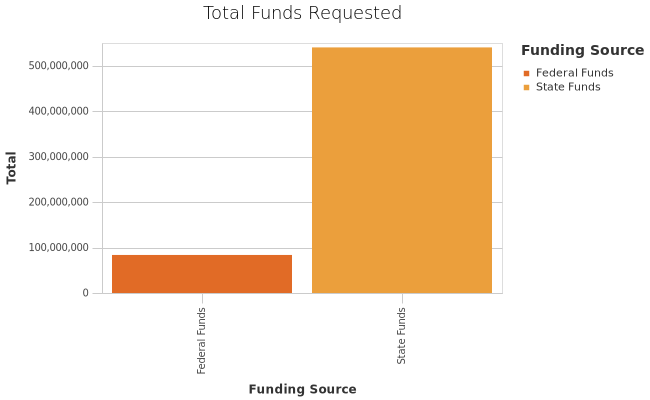!

In [7]:
#Bar Graph for showing the split of state versus federal funds
funding_all = cleaned_unpivoted_data[["state_total", "federal_total"]]

In [8]:
funding_all = funding_all.append(
    funding_all.sum(numeric_only=True), ignore_index=True
).tail(1)

In [9]:
funding_all = funding_all.T.reset_index()

In [10]:
funding_all = funding_all.rename(columns={"index": "Funding Source", 346: "Total"})
funding_all["Funding Source"] = funding_all["Funding Source"].replace(
    {"state_total": "State Funds", "federal_total": "Federal Funds"}
)

## How many applications did organizations submitted?
<hr style="border:2px solid #8CBCCB">

In [11]:
apps_submitted = (
    cleaned_unpivoted_data.groupby(["organization_name"])
    .agg({"project_upin": "count"})
    .reset_index()
    .groupby(["project_upin"])
    .agg({"organization_name": "count"})
    .reset_index()
    .rename(
        columns={
            "project_upin": "Applications",
            "organization_name": "Total Organizations",
        }
    )
)

In [12]:
apps_submitted["Applications"] = (
    apps_submitted["Applications"]
    .replace(
        {
            1: "one",
            2: "two",
            3: "three",
            4: "four",
            5: "five",
            6: "six",
            7: "seven",
            8: "eight",
            9: "nine",
            13: "thirteen",
        }
    )
    .str.title()
)

In [13]:
LEGEND = [
    "One",
    "Three",
    "Two",
    "Four",
    "Five",
    "Seven",
    "Six",
    "Nine",
    "Eight",
    "Thirteen",
]

In [14]:
#utilities.fancy_bar_chart(apps_submitted,LEGEND,"Applications","Total Organizations","Total Organizations","Number of Applications Submitted",)

In [15]:
display(
    Markdown(
         f"With the Consolidated Application process, organizations only need to submit one application. However, some entities submitted more than one."
        "<br>"f" Most organizations ({apps_submitted.iloc[0]['Total Organizations']}) submitted only <b>{apps_submitted.iloc[0]['Applications'].lower()}</b> application."
        "<br>"f" <b>{apps_submitted.tail(1).iloc[0]['Total Organizations']}</b> submitted <b>{apps_submitted.tail(1).iloc[0]['Applications'].lower()}</b> different applications, which is the highest number of applications."
       
    )
)

With the Consolidated Application process, organizations only need to submit one application. However, some entities submitted more than one.<br> Most organizations (38) submitted only <b>one</b> application.<br> <b>1</b> submitted <b>thirteen</b> different applications, which is the highest number of applications.

<img src= "bar_Total Organizations_by_Applications.png">

## What are the most popular grants by funds requested?
<hr style="border:2px solid #8CBCCB">

In [16]:
#Only select the cols of interest
federal_state_only = cleaned_unpivoted_data[
    [
        "_5311_funds",
        "_5311_f__funds",
        "_5311_cmaq_funds",
        "_5339_funds",
        "other_fed_funds_total",
        "lctop__state__funds",
        "sb1__state_of_good_repair__state__funds",
        "transit_development_act__state__funds",
        "other_state_funds",
    ]
]

# Get grand totals of each grant program.
federal_state_only = (
    federal_state_only.append(
        federal_state_only.sum(numeric_only=True), ignore_index=True
    )
    .tail(1)
    .T.reset_index()
    .rename(columns={"index": "Grant", 346: "amount requested"})
)

# Change grant names to something neater.
federal_state_only["Grant"] = federal_state_only["Grant"].replace(
    {
        "_5311_funds": "5311 (Fed)",
        "lctop__state__funds": "LCTOP (State)",
        "transit_development_act__state__funds": "Transit Development Act (State)",
        "other_state_funds": "Other State Funds",
        "_5339_funds": "5339 (Fed)",
        "_5311_f__funds": "5311(f) (Fed)",
        "sb1__state_of_good_repair__state__funds": "SB1. State of Good Repair (State)",
        "other_fed_funds_total": "Other Federal Funds",
        "_5311_cmaq_funds": "5311 CMAQ (Fed)",
        "local_total": "Local Funds",
        "federal_total": "Federal Total",
        "state_total": "State Total",
    }
)

In [17]:
#Sort dataframe from largest to least
federal_state_only = federal_state_only.sort_values("amount requested", ascending=False)
federal_state_only["amount requested"] = (
    federal_state_only["amount requested"].astype("int64").round(0)
)
#Adjust dollar amounts to Millions.
federal_state_only["amount requested (millions)"] = (
    "$"
    + (federal_state_only["amount requested"].astype(float) / 1000000)
    .round(0)
    .astype(str)
    + "M"
)

In [18]:
LEGEND = [
    "LCTOP (State)",
    "Other State Funds",
    "Transit Development Act (State)",
    "5311 (Fed)",
    "Other Federal Funds",
    "5339 (Fed)",
    "5311(f) (Fed)",
    "5311 CMAQ (Fed)",
    "SB1. State of Good Repair (State)",
]

In [19]:
#federal_state_only = utilities.fancy_bar_chart( federal_state_only,LEGEND,"Grant","amount requested","amount requested (millions)","Total Funds Requested",)

In [20]:
display(
    Markdown(
        f"Looking at a grant's popularity by the <b>total funds requested</b>, the top three programs are: {federal_state_only.iloc[0]['Grant']}, {federal_state_only.iloc[1]['Grant']}, and {federal_state_only.iloc[2]['Grant']}."
    )
)

Looking at a grant's popularity by the <b>total funds requested</b>, the top three programs are: LCTOP (State), Other State Funds, and Transit Development Act (State).

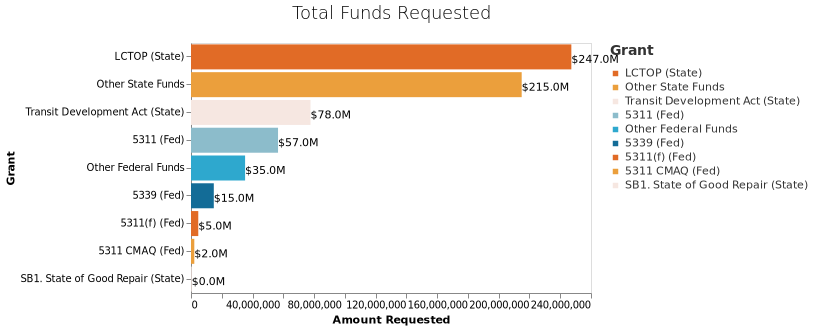

## What are the most popular grants by total applications?
<hr style="border:2px solid #8CBCCB">

In [21]:
combos = utilities.value_function(grouped_df, "all_programs")

In [22]:
Total = combos["values"].sum()
combos["Percentage of Total Applications"] = combos["values"] / Total
combos["Percentage of Total Applications"] = (
    combos["Percentage of Total Applications"].astype(float).map("{:.0%}".format)
)

In [23]:
combos = combos.rename(
    columns={"all_programs": "Combination of Grants", "values": "Total Applications"}
).head(10)

In [24]:
display(
    Markdown(
        f"Above, we looked at a grant's popularity from a monetary perspective."
        "<br>"f"However, popularity can also be determined by total applications for a particular grant or combination of grants."
        "<br>" 
        f"The most popular grants are {combos.iloc[0]['Combination of Grants']}, {combos.iloc[1]['Combination of Grants']}, and {combos.iloc[2]['Combination of Grants']} for this cycle."
    )
)

Above, we looked at a grant's popularity from a monetary perspective.<br>However, popularity can also be determined by total applications for a particular grant or combination of grants.<br>The most popular grants are LCTOP (State), 5311 (Fed), and 5311 (Fed),Transit Development Act (State) for this cycle.

In [25]:
combos.style.bar(subset=["Total Applications"], color="#8CBCCB").hide(
    axis="index"
).set_properties(**{"background-color": "white"}).set_table_styles([dict(selector="th", props=[("text-align", "center")])]).set_properties(**{'text-align': 'center'})

## What type of projects are being funded? 
<hr style="border:2px solid #8CBCCB">

In [26]:
project_types = cleaned_unpivoted_data.copy()
project_types = project_types.rename(
    columns={"short_description": "project type", "values": "Count of Projects"}
)

In [27]:
project_types = utilities.value_function(project_types, "project type").rename(
    columns={"values": "Count of Projects"}
)

In [28]:
display(
    Markdown(
        f"There are a total of <b>{cleaned_unpivoted_data.project_description.nunique()}</b> different project descriptions."
        "<br>" f"After re-grouping all of them into <b>{cleaned_unpivoted_data.short_description.nunique()}</b> major categories"
         "<br>" f"<b>{project_types.iloc[0]['project type']}</b> proved the be the most popular project category, with a total of <b>{project_types.iloc[0]['Count of Projects']}</b> applications."
          "<br>" f"<b>{project_types.tail(1).iloc[0]['project type']}</b> is the least popular: only totaling to <b>{project_types.tail(1).iloc[0]['Count of Projects']}</b> project."
    )
)

There are a total of <b>206</b> different project descriptions.<br>After re-grouping all of them into <b>10</b> major categories<br><b>Operating Assistance</b> proved the be the most popular project category, with a total of <b>204</b> applications.<br><b>Ridership Expansion</b> is the least popular: only totaling to <b>1</b> project.

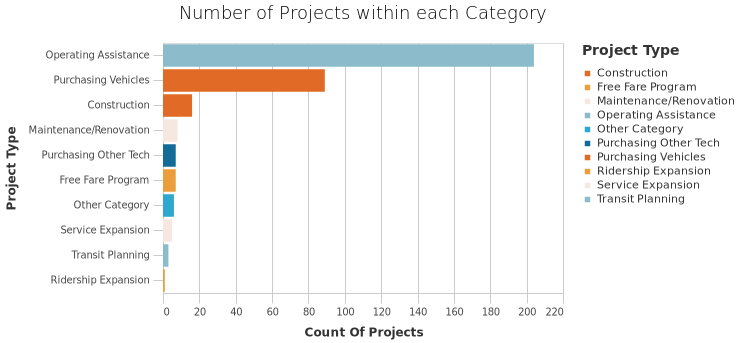!

In [29]:
#utilities.basic_bar_chart(project_types,"Count of Projects","project type", "project type","Number of Projects within each Category",)

## Are projects fully funded? 
<hr style="border:2px solid #8CBCCB">

In [30]:
fully_funded = utilities.value_function(cleaned_unpivoted_data, "fully_funded")
fully_funded = fully_funded.rename(columns={"values": "number of projects"})

fully_funded_percent = fully_funded.iloc[0]['number of projects']
fully_funded_percent = (fully_funded_percent/total_apps)
fully_funded_percent = format(fully_funded_percent, ".1%")

In [31]:
display(
    Markdown(
        f"After adding up the columns state total, federal total, and local total and comparing this sum against the total expenses column for each application, <b>{fully_funded_percent}</b> of projects are fully funded."
    )
)

After adding up the columns state total, federal total, and local total and comparing this sum against the total expenses column for each application, <b>76.0%</b> of projects are fully funded.

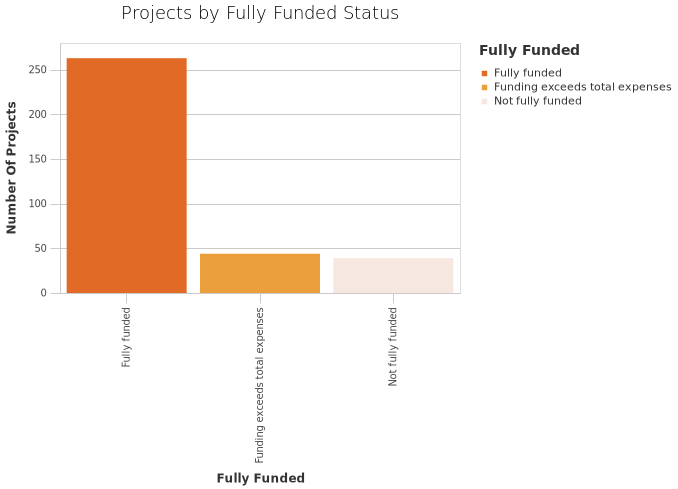!

In [32]:
# utilities.basic_bar_chart(fully_funded, "fully_funded", "number of projects", "fully_funded", "Projects by Fully Funded Status")

## Analyzing applications that include LCTOP and at least one other grant. 
<hr style="border:2px solid #8CBCCB">

In [33]:
#Only want programs with LCTOP. 
lctop_combos = grouped_df[(grouped_df.all_programs.str.contains("lctop", case=False))]

# Only want applications with more than one grant
lctop_combos = lctop_combos[(lctop_combos["count_of_funding_programs_applied"] > 1)]

#Group the dataframe by the Grant types, count the number of upin #s to get total applications, sort
lctop_combos = (
    lctop_combos.groupby(["all_programs"])
    .agg({"project_upin": "nunique"})
    .sort_values("project_upin", ascending=False)
    .reset_index()
)

In [34]:
display(
    Markdown(
         f"Overall, there are <b>{lctop_combos.project_upin.sum()}</b> applications that fit our criteria above."
        "<br>" f"There is a total of <b>{len(lctop_combos)}</b> different combinations that include LCTOP and at least one other program."
        "<br>" f"Explore the table below to see which combination is the most common."
       
    )
)

Overall, there are <b>23</b> applications that fit our criteria above.<br>There is a total of <b>12</b> different combinations that include LCTOP and at least one other program.<br>Explore the table below to see which combination is the most common.

In [35]:
lctop_combos.rename(columns = {'all_programs':'Grants', 'project_upin':'Total Applications'}).style.hide(axis="index").set_properties(
    **{"background-color": "white"}
).background_gradient().set_table_styles([dict(selector="th", props=[("text-align", "center")])]).set_properties(**{'text-align': 'center'})

## Analyzing by District.
<hr style="border:2px solid #8CBCCB">
Hover over the map to see details such as total applications and total funding requested by organizations within a Caltrans district.

In [36]:
TOOLTIP_KWARGS = {
    "min_width": 50,
    "max_width": 100,
    "font_size": "12px",
}

In [37]:
df_geometry["funding_percentile"] = df_geometry["funding_percentile"].astype("float64")

In [38]:
popup_dict = {
    "DISTRICT": "Caltrans district:",
    "project_upin": "Total applications from organizations in this district:",
    "funding_millions": "Total funding requested:",
    "funding_percentile": "Funding percentile:",
}

tooltip_dict = {
    "DISTRICT": "Caltrans district:",
    "project_upin": "Total applications from organizations in this district:",
    "funding_millions": "Total funding requested:",
    "funding_percentile": "Funding percentile:",
}

REGION_CENTROIDS = shared_utils.map_utils.REGION_CENTROIDS

color_scale = branca.colormap.StepColormap(
    colors=["#B9D6DF", "#2EA8CE", "#0B405B"],
    index=[0, 25, 75],
    vmin=0,
    vmax=100,
)
# color_scale

In [39]:
shared_utils.map_utils.make_folium_choropleth_map(
    df_geometry,
    plot_col="funding_percentile",
    popup_dict=popup_dict,
    tooltip_dict=tooltip_dict,
    colorscale=color_scale,
    fig_width=int(700),
    fig_height=int(700),
    zoom=REGION_CENTROIDS["CA"]["zoom"],
    centroid=REGION_CENTROIDS["CA"]["centroid"],
    title="Overview by Districts",
    legend_name="Funding Requested Percentile",
)

## Which organizations applied and how much did they ask for?
<hr style="border:2px solid #8CBCCB">

In [40]:
#Group by org name and the district it belongs to 
organizations = cleaned_unpivoted_data.groupby(
    [
        "organization_name",
        "full_district_name",
    ]
).agg({"total_state_fed_only": "sum"})

In [41]:
#Round monetary amount to millions
organizations["Total (M)"] = (
    "$" + (organizations["total_state_fed_only"].astype(float) / 1000000).round(2).astype(str) + "M"
)

#sort 
organizations = organizations.sort_values("total_state_fed_only", ascending=False).reset_index()


In [42]:
#Grab percentiles and add them to each organization
p75 = organizations.total_state_fed_only.quantile(0.75).astype(float)
p25 = organizations.total_state_fed_only.quantile(0.25).astype(float)
p50 = organizations.total_state_fed_only.quantile(0.50).astype(float)

def funding_range(row):
    if (row.total_state_fed_only > 0) and (row.total_state_fed_only < p25):
        return "25th"
    elif (row.total_state_fed_only >= p25) and (row.total_state_fed_only <= p75):
        return "50th"
    elif (row.total_state_fed_only >= p50) and (row.total_state_fed_only > p75):
        return "75th"
    else:
        return "$0"
organizations["Percentile"] = organizations.apply(
    lambda x: funding_range(x), axis=1
)

In [43]:
percentile_chart = (
    organizations.groupby("Percentile")
    .agg({"organization_name": "nunique"})
    .reset_index()
    .rename(columns={"organization_name": "Total Organizations"})
)

In [44]:
organizations_table = organizations[['organization_name','full_district_name','Total (M)']]
organizations_table2 = organizations_table.rename(columns = {'organization_name':'Organization', 'full_district_name':'District'}).set_index('Organization')

In [48]:
display(
    Markdown(
         f"The table below displays all the organizations and the total funding (state total plus federal total) they asked for, across all of their applications."
        "<br>"f"The table is in descending order. <b>{organizations_table.iloc[0]['organization_name']}</b> requested the most money, while <b>{organizations_table.tail(1).iloc[0]['organization_name']}</b> asked for the least"
       
    )
)

The table below displays all the organizations and the total funding (state total plus federal total) they asked for, across all of their applications.<br>The table is in descending order. <b>Peninsula Corridor Joint Powers Board</b> requested the most money, while <b>Placer County Public Works</b> asked for the least

In [49]:
display(HTML("<div style='height: 400px; overflow: auto; width: fit-content'>" +
             organizations_table2.style.render() +
             "</div>"))


In [50]:
organizations_table_styler_object = organizations_table.rename(columns = {'organization_name':'Organization', 'full_district_name':'District'}).style.hide(axis="index").set_properties(
    **{"background-color": "white"}).set_table_styles([dict(selector="th", props=[("text-align", "center")])]).set_properties(**{'text-align': 'center'})

In [51]:
#utilities.basic_bar_chart( percentile_chart, "Percentile", "Total Organizations", "Percentile", "Percentile Breakdown of Funds Requested",)

## What grants did each organization apply for?
<hr style="border:2px solid #8CBCCB">

In [52]:
grants_mix = grouped_df.copy().rename(
    columns={
        "organization_name": "Organization",
        "all_programs": "Grants",
    }
)

In [53]:
grants_mix = grants_mix.groupby(
    [  "Organization","Grants"]
).agg(
    {
        "Grants": "count",
    }
).rename(
    columns={
        "Grants": "# of Unique Applications",
    }
)


In [54]:
display(
    Markdown(
         f"The following table takes a deep dive into the the various grants an organization applied for and how many times it applied for that particular combination."
        "<br>"f"For example, <b>Amador Transit</b> applied for 5339(Fed) in four different applications, but applied for 5311 and LCTOP in two different applications."
    )
)

The following table takes a deep dive into the the various grants an organization applied for and how many times it applied for that particular combination.<br>For example, <b>Amador Transit</b> applied for 5339(Fed) in four different applications, but applied for 5311 and LCTOP in two different applications.

In [55]:
# Puts the scrollbar next to the DataFrame
display(HTML("<div style='height: 400px; overflow: auto; width: fit-content'>" +
             grants_mix.style.render() +
             "</div>"))


In [56]:
#With Styler. 
grants_mix3 = grants_mix.head(201).style.set_properties(**{"background-color": "white"}).bar(
    subset=["# of Unique Applications"], color="#2EA8CE"
).set_table_styles([dict(selector="th", props=[("text-align", "center")])]).set_properties(**{'text-align': 'center'})